<a href="https://colab.research.google.com/github/matchbou/kaggle-study-20190410/blob/master/combinatorial%20optimization-Via-Google%20Optimization%20Tools-201904121502.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<http://chachay.hatenablog.com/entry/2017/08/05/170756>

生産工程最適化問題

問題設定
こちらの問題設定をお借りして、3種類の機械(旋盤、ボール盤、フライス盤とかかな）の三種類を使う工程を3種類の部品(JOB)について、最適工程割り付けを行います。

機械と部品を便宜上、数字で呼ぶと扱いやすいので、

旋盤
ボール盤
フライス盤
としましょうか。工程は下記の通り（言うまでもなく、それぞれの部品の加工順序は守らなくてはなりません）

Job
(部品)	工程1	工程2	工程3
部品0	旋盤 3分	ボール盤 2分	フライス盤 3分
部品1	旋盤 2分	フライス盤 3分	ボール盤 4分
部品2	ボール盤 3分	旋盤 2分	フライス盤 1分

ソルバー用の書き方に書き換えると

 [m, t] : m 機械のID, t 加工時間(分)
 
jobs = [

    [[0,3],[1,2],[2,3]], # Job 0 / 部品0
    
    [[0,2],[2,3],[1,4]], # Job 1 / 部品1
    
    [[1,3],[0,2],[2,1]]  # Job 2 / 部品2
    ]
    
   
    

In [1]:
!pip install ortools

    100% |████████████████████████████████| 25.6MB 1.4MB/s 



Optimal Schedule Length: 11 

Optimal Schedule 

Machine 0: Job_1_0   Job_0_0   Job_2_1   
Machine 1: Job_2_0   Job_0_1   Job_1_2   
Machine 2: Job_1_1   Job_0_2   Job_2_2   

Time Intervals for Tasks

Machine 0: [0,2]     [2,5]     [5,7]     
Machine 1: [0,3]     [5,7]     [7,11]    
Machine 2: [2,5]     [7,10]    [10,11]   

[[[ 0.  2.  5.]
  [ 1.  5.  7.]
  [ 2.  7. 10.]]

 [[ 0.  0.  2.]
  [ 2.  2.  5.]
  [ 1.  7. 11.]]

 [[ 1.  0.  3.]
  [ 0.  5.  7.]
  [ 2. 10. 11.]]]


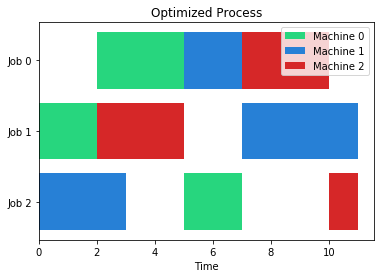

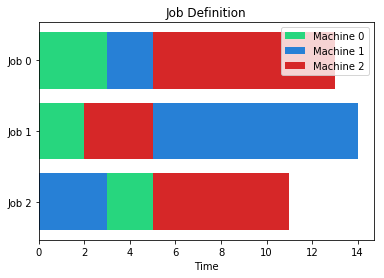

In [5]:

# OR toolsのインポート
from ortools.constraint_solver import pywrapcp

# 変数操作を楽にするためNumpy
import numpy as np

# 視覚化用
import matplotlib.pyplot as plt

def main():
    # ソルバー定義
    solver = pywrapcp.Solver('jobshop')

    # 機械の種類
    # 0. 旋盤
    # 1. ボール盤
    # 2. フライス盤
    machines_count = 3
    all_machines = range(0, machines_count)

    # Jobの定義
    # [m, t] : m 機械のID, t 加工時間(分)
    jobs = np.array([
      [[0,3],[1,2],[2,3]], # Job 0 / 部品0
      [[0,2],[2,3],[1,4]], # Job 1 / 部品1
      [[1,3],[0,2],[2,1]]  # Job 2 / 部品2
      ])
    jobs_count = 3
    all_jobs = range(0, jobs_count)

    machines = jobs[:,:,0].tolist()
    processing_times = jobs[:,:,1].tolist()
   
    # 全てのJobを直列に実施した場合の時間 
    # すなわち最悪値
    horizon = 0
    for i in all_jobs:
        horizon += sum(processing_times[i])

    # Jobをタスクの定義にばらします
    all_tasks = {}
    for i in all_jobs:
        for j in range(0, len(machines[i])):
            all_tasks[(i, j)] = solver.FixedDurationIntervalVar(0,
                                                              horizon,
                                                              processing_times[i][j],
                                                              False,
                                                              'Job_%i_%i' % (i, j))

    # 変数の設定と離接制約(機械は1度に1つのタスク)
    all_sequences = []
    all_machines_jobs = []
    for i in all_machines:
        machines_jobs = []
        for j in all_jobs:
            for k in range(0, len(machines[j])):
                if machines[j][k] == i:
                    machines_jobs.append(all_tasks[(j, k)])
        disj = solver.DisjunctiveConstraint(machines_jobs, 'machine %i' % i)
        all_sequences.append(disj.SequenceVar())
        solver.Add(disj)

    # 作業順序の順序制約
    for i in all_jobs:
        for j in range(0, len(machines[i]) - 1):
            solver.Add(all_tasks[(i, j + 1)].StartsAfterEnd(all_tasks[(i, j)]))
  
    # 目的変数定義
    obj_var = solver.Max([all_tasks[(i, len(machines[i])-1)].EndExpr()
                        for i in all_jobs])
    objective_monitor = solver.Minimize(obj_var, 1)
    
    # 探索的に目的変数が小さいものになるように…
    sequence_phase = solver.Phase([all_sequences[i] for i in all_machines],
                                solver.SEQUENCE_DEFAULT)
    vars_phase = solver.Phase([obj_var],
                            solver.CHOOSE_FIRST_UNBOUND,
                            solver.ASSIGN_MIN_VALUE)
    main_phase = solver.Compose([sequence_phase, vars_phase])
    
    # 解を保存する変数
    collector = solver.LastSolutionCollector()

    collector.Add(all_sequences)
    collector.AddObjective(obj_var)

    for i in all_machines:
        sequence = all_sequences[i];
        sequence_count = sequence.Size();
        for j in range(0, sequence_count):
            t = sequence.Interval(j)
            collector.Add(t.StartExpr().Var())
            collector.Add(t.EndExpr().Var())
    disp_col_width = 10

    # 最適化計算
    if solver.Solve(main_phase, [objective_monitor, collector]):
        print("\nOptimal Schedule Length:", collector.ObjectiveValue(0), "\n")
        sol_line = ""
        sol_line_tasks = ""
        print("Optimal Schedule", "\n")

        Result = np.zeros((3,3,3))
        
        for i in all_machines:
            seq = all_sequences[i]
            sol_line += "Machine " + str(i) + ": "
            sol_line_tasks += "Machine " + str(i) + ": "
            sequence = collector.ForwardSequence(0, seq)
            seq_size = len(sequence)

            for j in range(0, seq_size):
                t = seq.Interval(sequence[j]);
                sol_line_tasks +=  t.Name() + " " * (disp_col_width - len(t.Name()))

            for j in range(0, seq_size):
                t = seq.Interval(sequence[j]);
                sol_tmp = "[" + str(collector.Value(0, t.StartExpr().Var())) + ","
                sol_tmp += str(collector.Value(0, t.EndExpr().Var())) + "] "
                sol_line += sol_tmp + " " * (disp_col_width - len(sol_tmp)) 

            sol_line += "\n"
            sol_line_tasks += "\n"

            # 結果
            for j in range(0, seq_size):
                t = seq.Interval(sequence[j]);
                r, c = int(t.Name()[4]),int(t.Name()[6])
                Result[r,c,0]=i
                Result[r,c,1]=collector.Value(0, t.StartExpr().Var())
                Result[r,c,2]=collector.Value(0, t.EndExpr().Var())
            
        print(sol_line_tasks)
        print("Time Intervals for Tasks\n")
        print(sol_line)
        
        print(Result)
        
        # 結果可視化
        lglabels = ["Machine %i"%i for i in range(0,machines_count)]
        ylabels  = ["Job %i"%i for i in range(0,jobs_count)]
        colormap = {0:'#27d67e', 1:'#2780d6', 2:'#d62728'}
        color_mapper = lambda cps:[colormap[c] for c in cps]
        temp = np.array(processing_times).cumsum(axis=1)
        machines = np.array(machines)
        
        fig, ax = plt.subplots()

        for i in range(0,Result.shape[1]):
            ax.barh(all_jobs, Result[:,i,2]-Result[:,i,1], left=Result[:,i,1], color=color_mapper(Result[:,i,0]),align='center')
       
        ax.set_yticks(all_jobs)
        ax.set_yticklabels(ylabels)
        ax.invert_yaxis()
        ax.set_xlabel('Time')
        ax.set_title('Optimized Process')
        plt.legend(lglabels)
        
        fig, ax = plt.subplots()

        for i in range(0,temp.shape[1]):
            left_ind = temp[:,i-1] if i>0 else [0,0,0]
            ax.barh(all_jobs, temp[:,i], left=left_ind, color=color_mapper(machines[:,i]),align='center')
       
        ax.set_yticks(all_jobs)
        ax.set_yticklabels(ylabels)
        ax.invert_yaxis()
        ax.set_xlabel('Time')
        ax.set_title('Job Definition')
        plt.legend(lglabels)
        plt.show()

if __name__ == '__main__':
    main()